# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

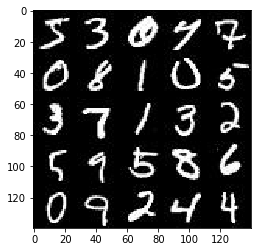

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

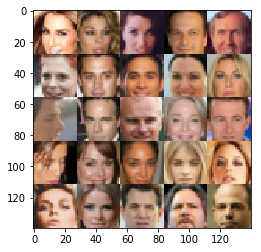

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_img')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return real_input_img, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    stddev = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        # 14x14x32
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * batch2, batch2)
        
        # 7x7x128
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * batch3, batch3)
        
        # 4x4x256
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    stddev = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # 7x7x256
        fc1 = tf.layers.dense(z, 4 * 4 * 512)
        fc1 = tf.reshape(fc1, (-1, 4, 4, 512))
        batch1 = tf.layers.batch_normalization(fc1, training=is_train)
        relu1 = tf.maximum(alpha * batch1, batch1)
        
        # 4x4x512
        conv2 = tf.layers.conv2d_transpose(relu1, 128, 4, strides=1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha * batch2, batch2)
        
        # 8x8x128
        conv3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha * batch3, batch3)
        
        # 16x16x64
        conv4 = tf.layers.conv2d_transpose(relu3, 32, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch4 = tf.layers.batch_normalization(conv4, training=is_train)
        relu4 = tf.maximum(alpha * batch4, batch4)
        
        # 32x32x32
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_real, 
            labels=tf.ones_like(dis_model_real) * (1 - smooth)))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, 
            labels=tf.zeros_like(dis_model_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, 
            labels=tf.ones_like(dis_model_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                          "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.8609... Generator Loss: 0.3553
Epoch 1/2... Discriminator Loss: 9.5038... Generator Loss: 0.0121
Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 2.9000
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 17.9134
Epoch 1/2... Discriminator Loss: 9.5495... Generator Loss: 0.0743
Epoch 1/2... Discriminator Loss: 1.8107... Generator Loss: 1.2157
Epoch 1/2... Discriminator Loss: 3.3865... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 1.7752... Generator Loss: 5.4647
Epoch 1/2... Discriminator Loss: 2.0354... Generator Loss: 4.2441
Epoch 1/2... Discriminator Loss: 1.7337... Generator Loss: 1.3792


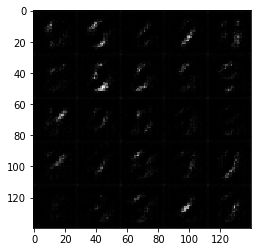

Epoch 1/2... Discriminator Loss: 1.5884... Generator Loss: 1.2156
Epoch 1/2... Discriminator Loss: 1.9678... Generator Loss: 0.9001
Epoch 1/2... Discriminator Loss: 1.6865... Generator Loss: 2.0139
Epoch 1/2... Discriminator Loss: 1.7338... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 2.6262... Generator Loss: 0.2413
Epoch 1/2... Discriminator Loss: 2.8358... Generator Loss: 0.2291
Epoch 1/2... Discriminator Loss: 2.1242... Generator Loss: 0.5307
Epoch 1/2... Discriminator Loss: 1.7315... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 1.7582... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.5799... Generator Loss: 0.8454


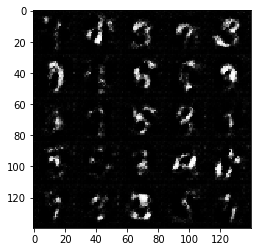

Epoch 1/2... Discriminator Loss: 1.7160... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 1.3278
Epoch 1/2... Discriminator Loss: 1.9087... Generator Loss: 2.1658
Epoch 1/2... Discriminator Loss: 1.6237... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.7242... Generator Loss: 0.6563
Epoch 1/2... Discriminator Loss: 1.6325... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 1.0516
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 1.3070


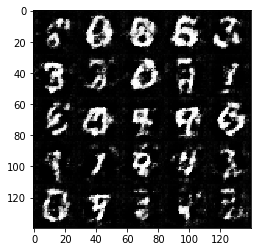

Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 1.9684
Epoch 1/2... Discriminator Loss: 1.8465... Generator Loss: 0.4232
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 2.2558
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 1.3677
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 1.4372
Epoch 1/2... Discriminator Loss: 1.9827... Generator Loss: 0.4142
Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 1.6819
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 1.2132
Epoch 1/2... Discriminator Loss: 1.7392... Generator Loss: 2.5497
Epoch 1/2... Discriminator Loss: 1.9750... Generator Loss: 0.3658


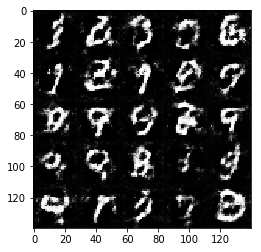

Epoch 1/2... Discriminator Loss: 1.5486... Generator Loss: 2.0595
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 0.8180
Epoch 1/2... Discriminator Loss: 1.7571... Generator Loss: 2.6087
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 1.8256
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.4830
Epoch 1/2... Discriminator Loss: 1.5241... Generator Loss: 0.6072
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.7706... Generator Loss: 2.6052
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 1.6686


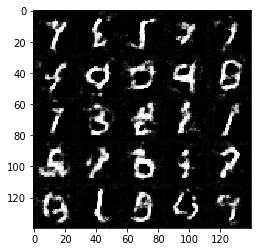

Epoch 1/2... Discriminator Loss: 1.7945... Generator Loss: 0.4360
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.5832
Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 2.6645
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 1.1212
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.5924
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 0.9722


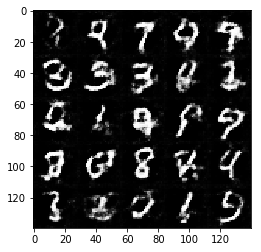

Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 1.8715
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 1.7208
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.6632... Generator Loss: 0.4125
Epoch 1/2... Discriminator Loss: 1.8228... Generator Loss: 0.4751
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 2.1835
Epoch 1/2... Discriminator Loss: 1.8141... Generator Loss: 0.3677
Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 0.5594
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 1.4561


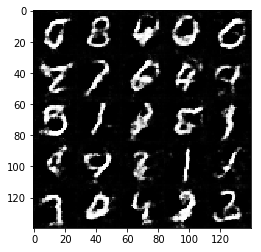

Epoch 1/2... Discriminator Loss: 1.8830... Generator Loss: 0.3935
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 2.3691
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 1.8129
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 1.3001
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 0.9454
Epoch 1/2... Discriminator Loss: 1.7575... Generator Loss: 0.4003
Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.6757
Epoch 1/2... Discriminator Loss: 1.4937... Generator Loss: 1.9174
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.6294


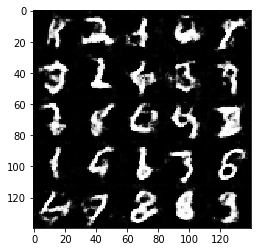

Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 0.8990
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 2.0033
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 1.2504
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.7228... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 1.7342... Generator Loss: 2.5158
Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 1.7491
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.7056


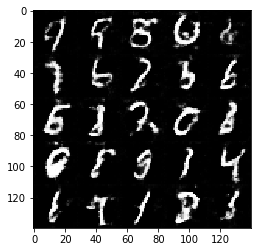

Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 1.8514
Epoch 1/2... Discriminator Loss: 1.0399... Generator Loss: 1.5203
Epoch 1/2... Discriminator Loss: 1.6616... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 1.1579
Epoch 2/2... Discriminator Loss: 1.1279... Generator Loss: 1.4720
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 1.7400
Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.4542... Generator Loss: 0.4877


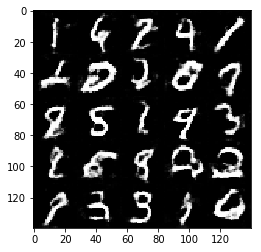

Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 1.0423
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 1.1903
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 1.3286
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 1.1845
Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 1.3087
Epoch 2/2... Discriminator Loss: 1.6074... Generator Loss: 0.4771
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 1.0909
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.6201
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 2.0061
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.5945


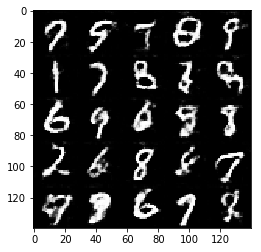

Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 1.4896
Epoch 2/2... Discriminator Loss: 1.0131... Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 1.0531... Generator Loss: 1.9723
Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.7179
Epoch 2/2... Discriminator Loss: 1.6165... Generator Loss: 2.4916
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 1.5149... Generator Loss: 2.1836
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 1.0706


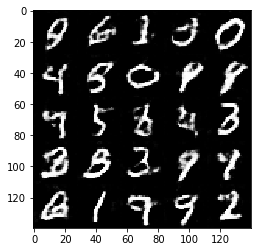

Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 0.9350
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 2.0289
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.7325
Epoch 2/2... Discriminator Loss: 1.0176... Generator Loss: 1.7292
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 1.0908
Epoch 2/2... Discriminator Loss: 1.6117... Generator Loss: 2.6907
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 1.2686
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 1.6762


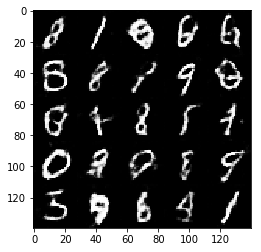

Epoch 2/2... Discriminator Loss: 1.4298... Generator Loss: 1.5700
Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 0.5891
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 1.9140
Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 0.7209
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.9908
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 1.8836
Epoch 2/2... Discriminator Loss: 1.0615... Generator Loss: 1.2416
Epoch 2/2... Discriminator Loss: 1.7268... Generator Loss: 3.1785


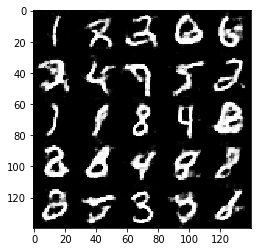

Epoch 2/2... Discriminator Loss: 1.4881... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 2.0317... Generator Loss: 2.5261
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.6726... Generator Loss: 0.4509
Epoch 2/2... Discriminator Loss: 1.6223... Generator Loss: 0.5188
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.5823
Epoch 2/2... Discriminator Loss: 1.7465... Generator Loss: 0.3880
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 1.2318


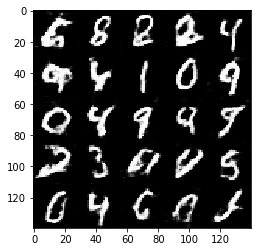

Epoch 2/2... Discriminator Loss: 1.6810... Generator Loss: 0.4158
Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 1.2856
Epoch 2/2... Discriminator Loss: 0.9257... Generator Loss: 1.3101
Epoch 2/2... Discriminator Loss: 1.5735... Generator Loss: 0.5452
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.1499... Generator Loss: 1.4652
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.6351
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 1.1372
Epoch 2/2... Discriminator Loss: 1.6351... Generator Loss: 0.4212
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 1.4228


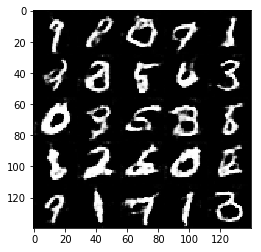

Epoch 2/2... Discriminator Loss: 1.7847... Generator Loss: 0.3964
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 1.4241
Epoch 2/2... Discriminator Loss: 1.5342... Generator Loss: 0.5283
Epoch 2/2... Discriminator Loss: 1.5730... Generator Loss: 0.4887
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 1.9368
Epoch 2/2... Discriminator Loss: 0.9000... Generator Loss: 1.4606
Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 1.6197
Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.5517
Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.7671


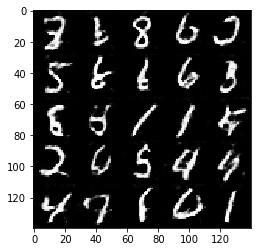

Epoch 2/2... Discriminator Loss: 1.5819... Generator Loss: 0.4748
Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 1.7303
Epoch 2/2... Discriminator Loss: 2.1471... Generator Loss: 0.2941
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 2.0924
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 1.1135
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 1.5936
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 1.0733... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 1.7060... Generator Loss: 0.4194
Epoch 2/2... Discriminator Loss: 1.7834... Generator Loss: 0.4430


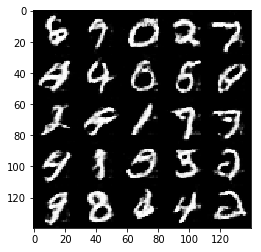

Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 0.7335
Epoch 2/2... Discriminator Loss: 1.7103... Generator Loss: 2.5221
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 1.1751
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.6190


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 10.7836... Generator Loss: 0.0013
Epoch 1/1... Discriminator Loss: 5.4267... Generator Loss: 0.2432
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 3.5163
Epoch 1/1... Discriminator Loss: 2.7503... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 2.7703... Generator Loss: 20.7552
Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 25.9992
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 12.3706
Epoch 1/1... Discriminator Loss: 2.2798... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 1.9761
Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 2.4752


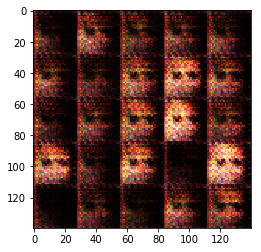

Epoch 1/1... Discriminator Loss: 2.1484... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 3.4315
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 6.6290
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 2.1879
Epoch 1/1... Discriminator Loss: 2.5471... Generator Loss: 7.8275
Epoch 1/1... Discriminator Loss: 3.5867... Generator Loss: 0.1999
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 4.6704
Epoch 1/1... Discriminator Loss: 1.7548... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 2.5911... Generator Loss: 0.2714
Epoch 1/1... Discriminator Loss: 1.8158... Generator Loss: 3.0022


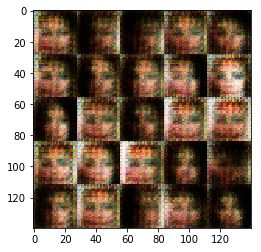

Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 2.7692
Epoch 1/1... Discriminator Loss: 1.8685... Generator Loss: 2.5209
Epoch 1/1... Discriminator Loss: 1.8234... Generator Loss: 3.6030
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 2.1707
Epoch 1/1... Discriminator Loss: 2.2326... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 2.1225... Generator Loss: 4.2729
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.5243
Epoch 1/1... Discriminator Loss: 1.6847... Generator Loss: 3.3110
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 2.0945


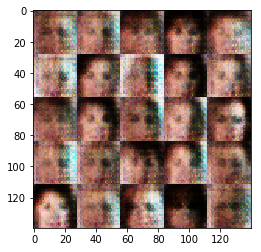

Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 2.8117
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 4.2245
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 2.8937
Epoch 1/1... Discriminator Loss: 2.7318... Generator Loss: 0.2422
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 2.5116... Generator Loss: 4.1671
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.7623
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 1.9840
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9929


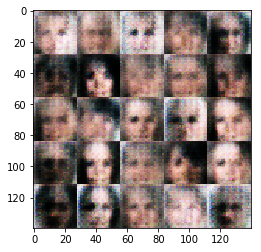

Epoch 1/1... Discriminator Loss: 1.9551... Generator Loss: 3.0127
Epoch 1/1... Discriminator Loss: 2.0921... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.7018... Generator Loss: 1.6923
Epoch 1/1... Discriminator Loss: 1.8865... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 1.5257
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 2.7096


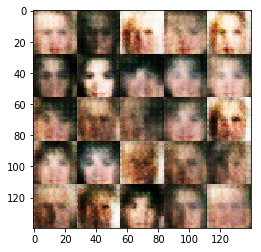

Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 3.4274
Epoch 1/1... Discriminator Loss: 2.6441... Generator Loss: 2.5966
Epoch 1/1... Discriminator Loss: 2.1503... Generator Loss: 2.7809
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 2.0376
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 1.9219


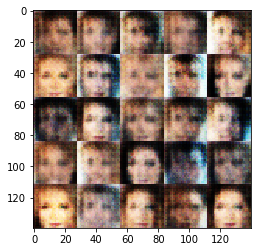

Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 2.0644
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.3778
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 2.4076
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8712


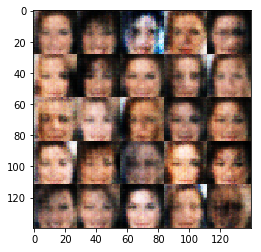

Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.6509
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.7322... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.6213... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.7118... Generator Loss: 2.7759
Epoch 1/1... Discriminator Loss: 1.7702... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.6310... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 1.8415... Generator Loss: 1.0553


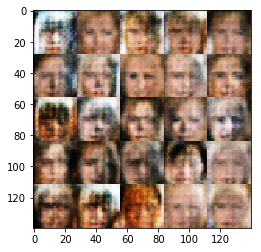

Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 2.0866... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 1.7121
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 1.3969
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.6732


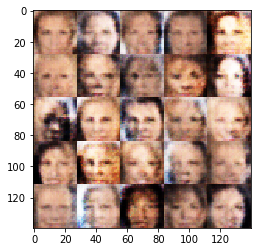

Epoch 1/1... Discriminator Loss: 1.6876... Generator Loss: 1.1671
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 1.2811
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 1.2667
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7469


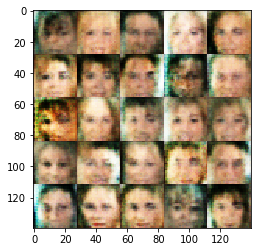

Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 1.7835... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 1.2578
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 2.0319... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.7364... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 1.0427


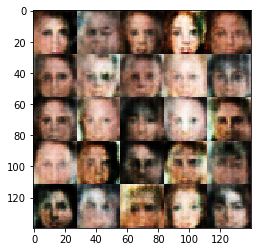

Epoch 1/1... Discriminator Loss: 1.6963... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 1.4362
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 1.2225


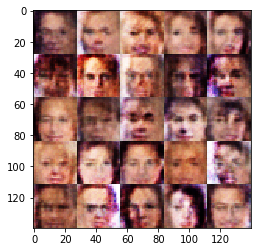

Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.6597
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.8323... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.5323
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 1.1283


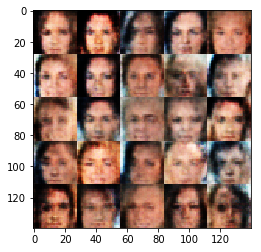

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.8683... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 1.7330
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.3063


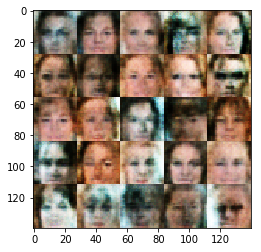

Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.8062... Generator Loss: 0.3895
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.8801... Generator Loss: 0.4056


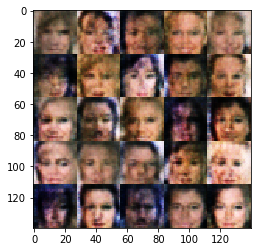

Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 1.7436... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.7102... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 1.7961... Generator Loss: 2.0447


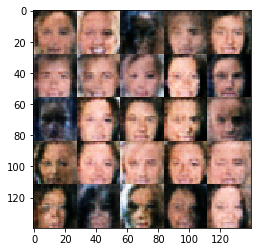

Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.3669
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8125


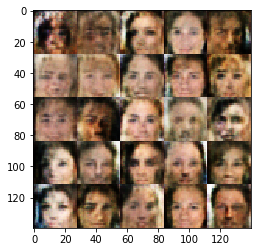

Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.6050... Generator Loss: 1.7873
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 1.2743
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.6075


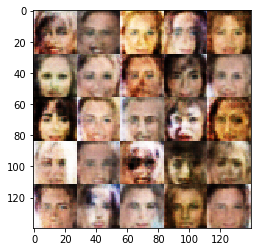

Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.1426
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7785


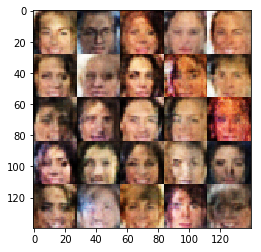

Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.4630
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.5949


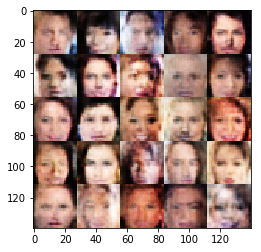

Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.6225... Generator Loss: 1.3811
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 1.6061


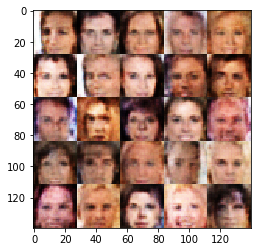

Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 1.2253


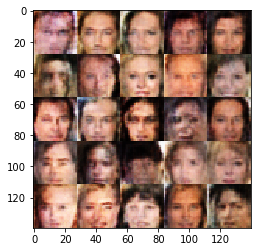

Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 1.1138


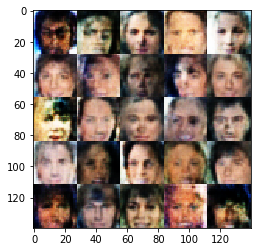

Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 1.8000
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 1.1560


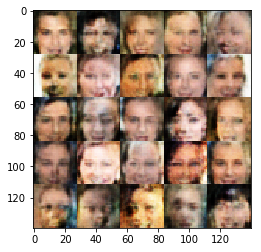

Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 1.3751
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6433


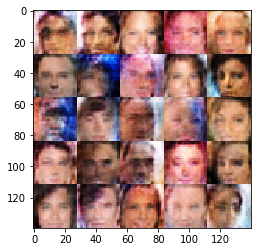

Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.6304
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.6041... Generator Loss: 0.4545


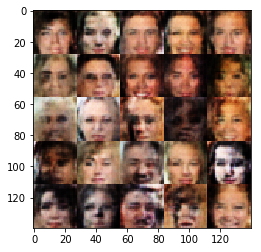

Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 1.3893


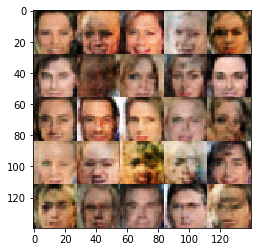

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.9471


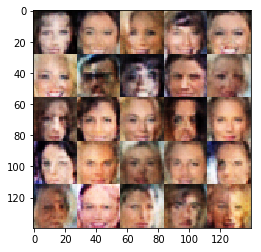

Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 1.5432
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7150


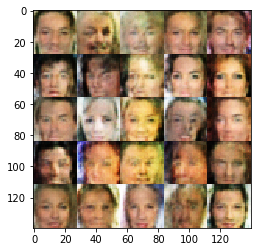

Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 1.7546
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.4003
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.4600


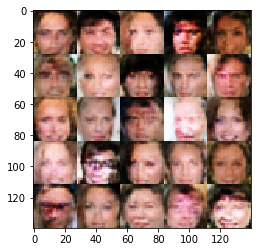

Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 1.4824
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6770


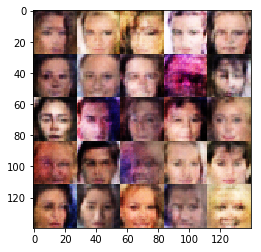

Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 1.9632
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.6108


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.